In [22]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.constants import G, k_B
from astropy.visualization import quantity_support
import os

Matplotlib configuration

In [2]:
plt.rcParams['figure.figsize'] = [8, 3]
plt.rcParams['figure.dpi'] = 200
quantity_support()  

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x72051c46d7b0>

Drop null entries of dataframe and convert to numpy array

In [3]:
def array(df):
    return df.dropna().to_numpy()

In [57]:
def model_id(model_file):
    return model_file[6:10]

---
Mass of star $M$ ($M_\odot$)

In [42]:
M_star = 20 * u.M_sun
directory = os.path.relpath(f"{int(M_star.value)}M_models")
files = [ name for name in os.listdir(directory) if name.endswith(".csv") ]
files

['model_1166.csv',
 'model_1270.csv',
 'model_1376.csv',
 'model_1342.csv',
 'model_1692.csv',
 'model_1518.csv',
 'model_1304.csv',
 'model_1586.csv',
 'model_1796.csv',
 'model_1650.csv',
 'model_1552.csv',
 'model_1726.csv',
 'model_1446.csv',
 'model_1866.csv',
 'model_1832.csv',
 'model_1412.csv',
 'model_1236.csv',
 'model_1202.csv',
 'model_1762.csv',
 'model_1482.csv']

---
### MESA simulation data for $^{23}$Na

In [124]:
stars = [
    {
        "id": model_id(file),
        "file": file,
        "sim": pd.read_csv(os.path.join(directory, file)),
    }
    for file in files
]
stars[0]["sim"]

,radius,log_mass_fraction,log_T_core,radius_temp,log_Ts,radius_rho,log_rhos,log_star_age
0,0.000166,-1.175284,8.887822,0.000421,8.887582,0.000546,5.289785,6.989258
1,0.000634,-1.174788,NaN,0.000882,8.887582,0.001008,5.286735,NaN
2,0.001101,-1.175284,NaN,0.001344,8.887651,0.001470,5.286735,NaN
3,0.001570,-1.185216,NaN,0.001806,8.887720,0.001931,5.286181,NaN
4,0.002038,-1.194155,NaN,0.002267,8.887530,0.002393,5.281467,NaN
...,...,...,...,...,...,...,...,...
61,NaN,NaN,NaN,0.028466,8.814913,0.006927,5.226667,NaN
62,NaN,NaN,NaN,0.028908,8.812289,NaN,NaN,NaN
63,NaN,NaN,NaN,0.029267,8.810039,NaN,NaN,NaN
64,NaN,NaN,NaN,0.029703,8.807082,NaN,NaN,NaN


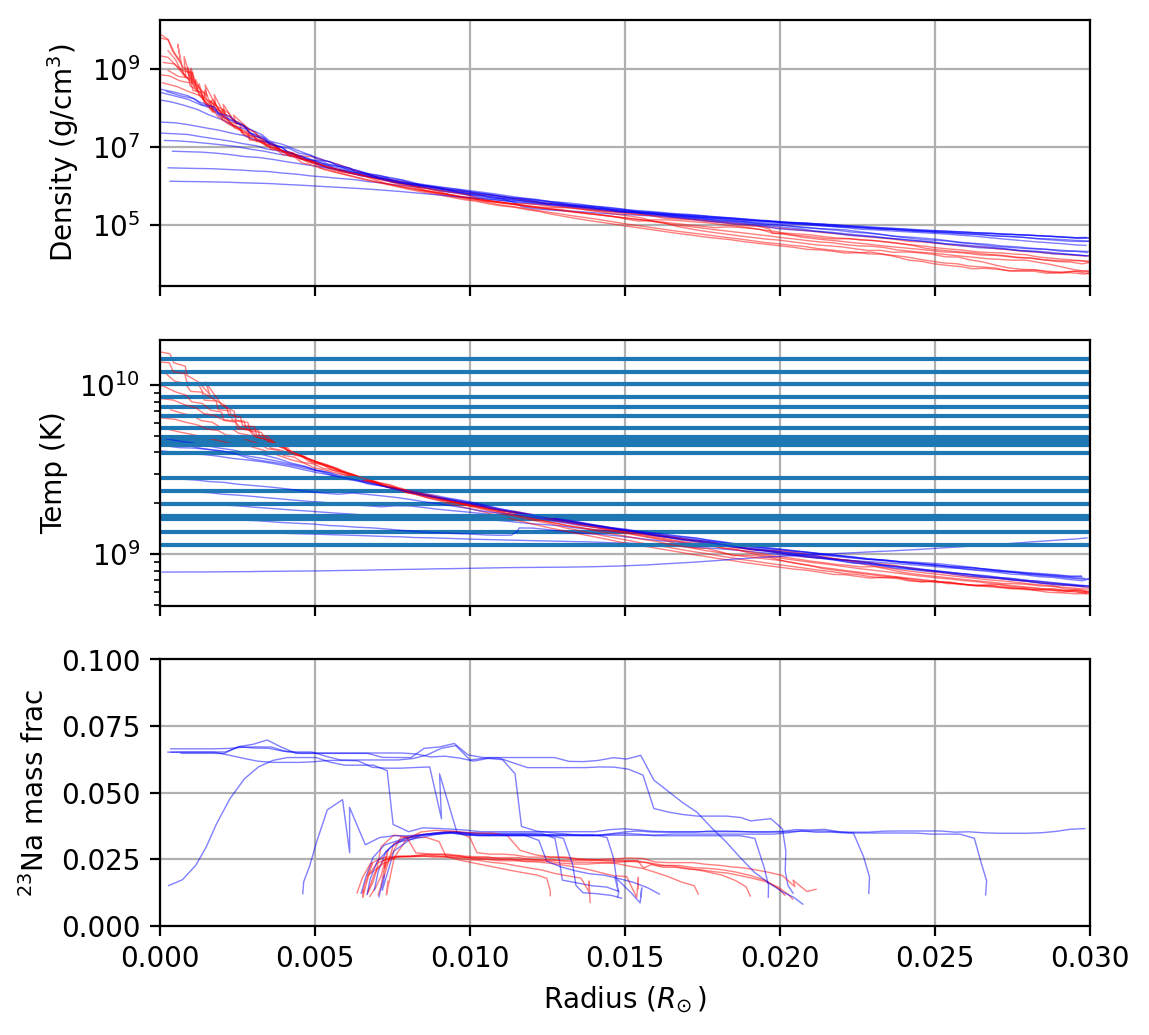

In [181]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(6, 6))

for star in stars:
    sim = star["sim"]
    id = star["id"]

    r_rho_raw = array(sim["radius_rho"]) * u.R_sun
    rho_raw   = (10 ** array(sim["log_rhos"])) * u.g / (u.cm**3)
    
    r_T_raw   = array(sim["radius_temp"]) * u.R_sun
    T_raw     = (10 ** array(sim["log_Ts"])) * u.K
    T_core    = (10 ** sim["log_T_core"][0]) * u.K
    color  =  "red" if T_raw[0] > 5e9 * u.K else "blue"
    
    r_Z_raw   = array(sim["radius"]) * u.R_sun
    Z_raw     = 10 ** array(sim["log_mass_fraction"])
        
    
    plt.sca(axs[0])
    plt.yscale('log')
    plt.plot(r_rho_raw, rho_raw, lw=0.5, alpha=0.5, c=color)
    plt.ylabel("Density (g/cm$^3$)")
    
    plt.sca(axs[1])
    plt.yscale('log')
    plt.plot(r_T_raw, T_raw, lw=0.5, alpha=0.5, c=color)
    plt.axhline(T_core)
    plt.ylabel("Temp (K)")

    plt.sca(axs[2])
    plt.ylim(0, 0.1)
    plt.xlim(0, rmax.value)
    plt.plot(r_Z_raw, Z_raw, label=id, lw=0.5, alpha=0.5, c=color)
    plt.ylabel("$^{23}$Na mass frac")
    plt.xlabel("Radius ($R\!_\odot$)")
    # plt.legend(loc='lower right')

    star.update({
        
        "r_rho_raw": r_rho_raw,
        "rho_raw": rho_raw,
        
        "r_T_raw": r_T_raw,
        "T_raw": T_raw,
        "T_core": T_core,
        
        "r_Z_raw": r_Z_raw,
        "Z_raw": Z_raw,

        "color": color,
        
    })

for ax in axs:
    plt.sca(ax)
    plt.grid()

plt.show()

Unified array of radii ("shells")

Raw values, which don't correspond exactly to the shell radii

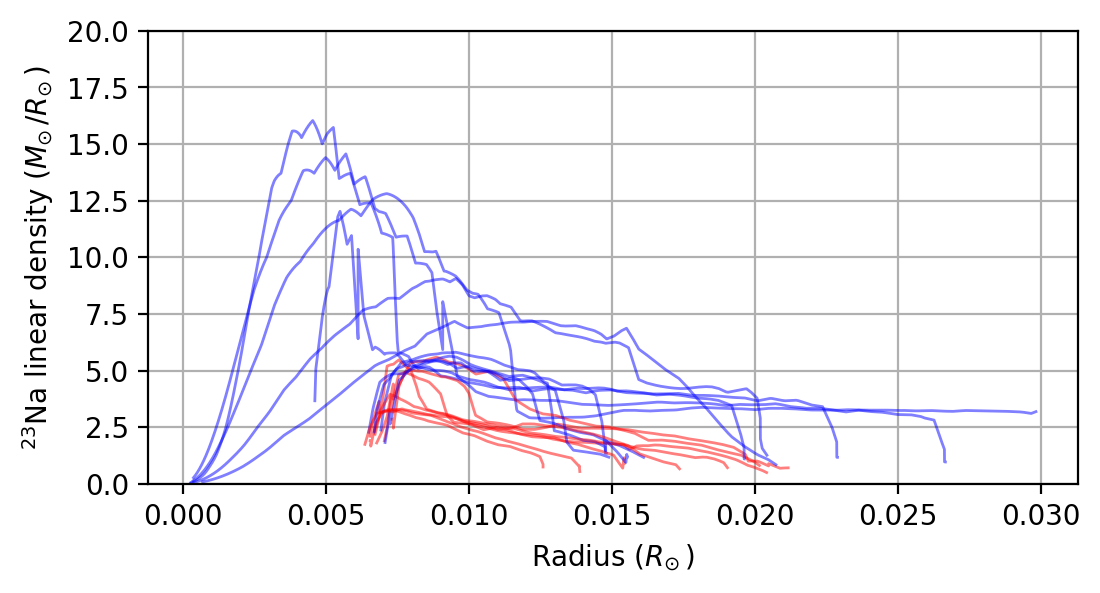

In [202]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

samples = int(1e5)

for star in stars:
    
    rho_raw = star["rho_raw"]
    r_rho_raw = star["r_rho_raw"]
    
    T_raw = star["T_raw"]
    r_T_raw = star["r_T_raw"]
    
    Z_raw = star["Z_raw"]
    r_Z_raw = star["r_Z_raw"]

    color = star["color"]
    
    r_min = np.min(r_Z_raw.to_value(u.R_sun)) * u.R_sun
    r_max = np.max(r_Z_raw.to_value(u.R_sun)) * u.R_sun

    # array of radii ("shells") to sample
    r = np.linspace(r_min, r_max, samples)

    # thickness of each shell
    dr = r_max/samples

    # volume of each shell
    dV = 4 * np.pi * r*r * dr

    # raw quantities, interpolated over the shells
    T = np.interp(r, r_T_raw, T_raw)
    rho = np.interp(r, r_rho_raw, rho_raw)
    Z = np.interp(r, r_Z_raw, Z_raw)

    # mass of 23Na in each shell
    dM = (Z * rho * dV).to(u.g)

    # mass concentration
    dMdr = dM.to(u.M_sun) / dr

    # total mass of 23Na
    M = np.sum(dM).to_value(u.M_sun)

    plt.ylim(0, 20)
    plt.plot(r, dMdr, label=f"{M:.3f} $M\!_\odot$", lw=1, c=color, alpha=0.5)

    star.update({
        "r": r,
        "T": T,
        "rho": rho,
        "Z": Z,
        "dM": dM,
        "M": M,
    })
    
# plt.legend()
plt.ylabel("$^{23}$Na linear density ($M\!_\odot/R\!_\odot$)")
plt.xlabel("Radius ($R\!_\odot$)")
plt.grid()

---
### Plotting parameters

Flavor-singet axial-vector matrix element $S$

In [16]:
S_range = np.linspace(-0.25, 2, 100)

Axion mass $m_a$ (eV)

In [178]:
m_a_range = np.linspace(0, 5, 100) * u.eV

---

Axion luminosity for $^{23}$Na

$\displaystyle L 
= \left[\frac{m_a}{\text{eV}}\right]^2
\times 7.2\cdot10^8\frac{\text{erg}}{\text{g}\cdot\text{s}}
\times [1 + 1.07S]^2
\times \int \frac{dM(r)}{1.5 + \exp\left(\cfrac{\beta_3}{k\cdot T(r)}\right)}
$,
$\beta_3 = 440\text{ keV}$


Energy of nuclear decay in $^{23}$Na, i.e. the energy per axion

In [160]:
E_a = 440 * u.keV

Axion number flux in star

In [224]:
N_a = lambda S, m_a, dM, T: ( (
    ( (m_a / u.eV)**2 ) 
    * (7.2e8 * u.erg / (u.g * u.s) ) 
    * ((1 + 1.07*S)**2) 
    * np.sum(dM / (1.5 + np.exp( E_a / (k_B * T) )))
) / E_a ).to(u.Hz)

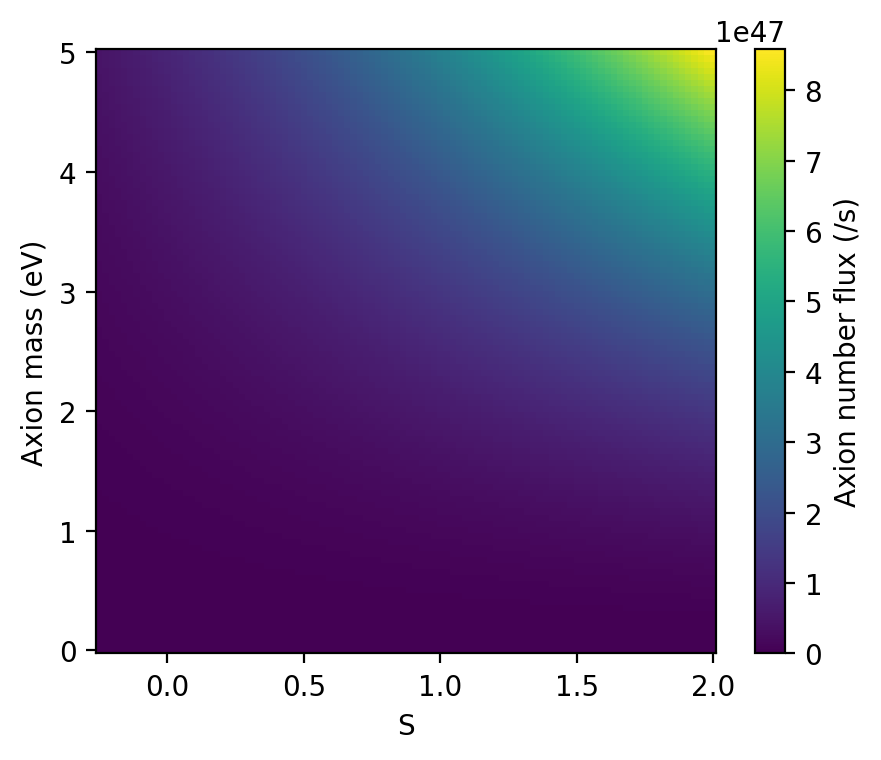

In [225]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(5, 4))
plt.sca(ax)
S_grid, m_a_grid = np.meshgrid(S_range, m_a_range)
plt.pcolormesh(S_grid, m_a_grid, N_a(S_grid, m_a_grid, stars[0]["dM"], stars[0]["T"]).value, cmap="viridis")
plt.xlabel("S")
plt.ylabel("Axion mass (eV)")
plt.colorbar(label="Axion number flux (/s)")
plt.show()

Text(0, 0.5, 'Number of models')

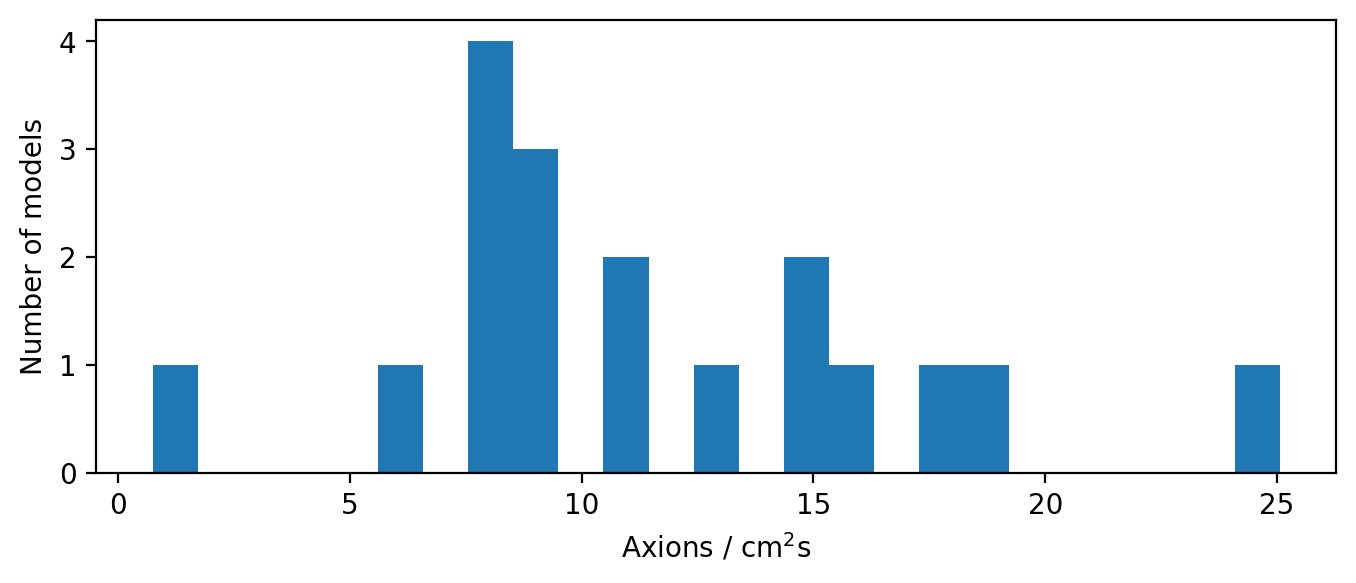

In [228]:
fluxes = list()
for star in stars:
    dM = star["dM"]
    T = star["T"]
    flux = (N_a(1e-9, 1 * u.eV, dM, T) / ((8 * u.kpc) **2)).to_value(u.Hz / u.cm / u.cm)
    fluxes.append(flux)
    
plt.hist(fluxes, bins=25)
plt.xlabel("Axions / cm$^2$s")
plt.ylabel("Number of models")


In [235]:
(N_a(1e-9, 1 * u.eV, np.array([0.045]) * u.M_sun, np.array([1e9]) * u.K) / ((8 * u.kpc) **2)).to_value(u.Hz / u.cm / u.cm)

0.900687753904928